In [1]:
import os
import sys
import subprocess
import glob
import pathlib

# logic to accomodate Google Colab
try:
    import google.colab

    ENV_IS_CL = True

    root = pathlib.Path("/content/t-route").resolve()
    subprocess.run(
        [
            "git",
            "clone",
            "-b",
            "segment-merge",
            "https://github.com/awlostowski-noaa/t-route.git",
        ]
    )

    ! pip install geopandas
    ! pip install zipfile
    ! pip install us
    ! pip install netcdf4
    ! pip install progressbar

except:
    ENV_IS_CL = False
    root = pathlib.Path("..").resolve()

fortran_source_dir = os.path.join(
    root, "src", "fortran_routing", "mc_pylink_v00", "MC_singleSeg_singleTS"
)
sys.path.append(fortran_source_dir)
routing_v02_dir = os.path.join(root, "src", "python_routing_v02")
sys.path.append(routing_v02_dir)    
sys.path.append(os.path.join(root, "src", "python_framework_v02"))
sys.path.append(os.path.join(root, "src", "python_framework_v01"))

# load needed scientific libraries
from functools import partial
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter, deque
from itertools import chain
import requests
import zipfile
import io
import us
import time
from progressbar import ProgressBar

# turn off warnings
import warnings

warnings.simplefilter("ignore")

# import t-route functions for network analysis
import nhd_network_utilities_v02 as nnu
import nhd_io
import nhd_network
import mc_reach
import network_dl


In [2]:
#####################################################################################
# Load, mask, and prep network data - Cape Fear River Basin, North Carolina
#####################################################################################

# Create directory path variable for test/input/geo, where NHD data and masks are stored
test_folder = os.path.join(root, r"test")
geo_input_folder = os.path.join(test_folder, r"input", r"geo")

# Load network meta data for the Cape Fear Basin
supernetwork = "CapeFear_FULL_RES"
network_data = nnu.set_supernetwork_data(
    supernetwork=supernetwork, geo_input_folder=geo_input_folder
)

# if the NHDPlus RouteLink file does not exist, download it.
if not os.path.exists(network_data["geo_file_path"]):
    filename = os.path.basename(network_data["geo_file_path"])
    network_dl.download(network_data["geo_file_path"], network_data["data_link"])

# read-in NHD data, retain copies for viz- and full network analysis purposes
data = nhd_io.read(network_data["geo_file_path"])
data_full = data.copy()
dat_geo = data.copy()

# select only the necessary columns needed for network analysis and computation
cols = [v for c, v in network_data.items() if c.endswith("_col")]
data = data[cols]

# set the Data Frame index (row labels) to the key column - "featureID"
data = data.set_index(network_data["key_col"])
dat_geo = dat_geo.set_index(network_data["key_col"])

# mask NHDNetwork to isolate test network - full resolution Cape Fear basin, NC
if "mask_file_path" in network_data:
    data_mask = nhd_io.read_mask(
        network_data["mask_file_path"], layer_string=network_data["mask_layer_string"],
    )
    data = data.filter(data_mask.iloc[:, network_data["mask_key"]], axis=0)
    dat_geo = dat_geo.filter(data_mask.iloc[:, network_data["mask_key"]], axis=0)

# sort data by index
data = data.sort_index()

# replace downstreams for terminal segments
data = nhd_io.replace_downstreams(data, network_data["downstream_col"], 0)

print("NHD data loaded, masked, and prepped")


NHD data loaded, masked, and prepped


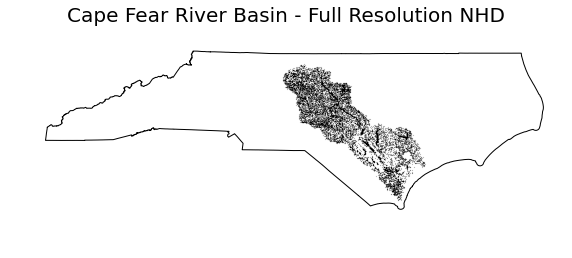

In [3]:
#####################################################################################
# Visualize the Cape Fear basin
#####################################################################################

# create a pandas GeoDataFrame for viz purposes
gdf = gpd.GeoDataFrame(dat_geo, geometry=gpd.points_from_xy(dat_geo.lon, dat_geo.lat))

################################################
# Download North Carolina shapefile for basemap
################################################
shape_url = us.states.NC.shapefile_urls()["state"]
local_path = "../test/input/geo/NorthCarolina_state_shape"

# Download and extract shapefile
r = requests.get(shape_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(path=local_path)

# get extracted filenames
filenames = [
    y
    for y in sorted(z.namelist())
    for ending in ["dbf", "prj", "shp", "shx"]
    if y.endswith(ending)
]
dbf, prj, shp, shx = [filename for filename in filenames]

# load shapefile with GeoPandas
nc = gpd.read_file(local_path + "/" + shp)

################################################
# Create a map
################################################

# create a basemap
base = nc.plot(color="white", edgecolor="black")

# add our stream network, segments are represented as small points (nodes in the network)
gdf.plot(ax=base, markersize=0.01, color="black")

# crop the map extent
base.set_xlim(-85, -75)
base.set_ylim(33, 37)

# turn axes off
base.axis("off")

# get current figure and set size
fig = plt.gcf()
fig.set_size_inches(10, 15)

# add a title and display
plt.title("Cape Fear River Basin - Full Resolution NHD", fontsize=20)

# display the map in output

plt.show()
fig.savefig("../doc/cape_fear_network.png", bbox_inches='tight')


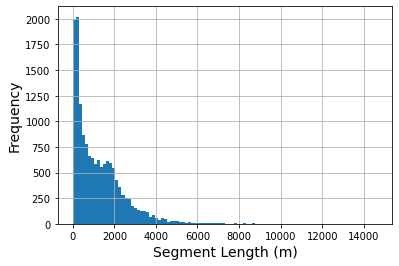

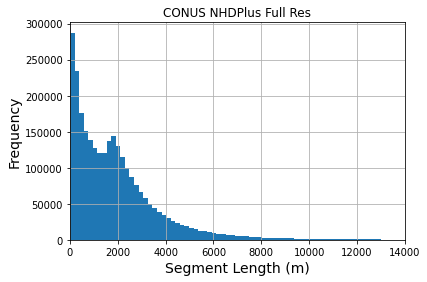

There are 1014661 segments in the supernetwork shorter than the threshold length.
That is 37% of all segments in the supernetwork!


In [4]:
#####################################################################################
# Analyze the distribution of segment lengths in the native NHD Full Res data
#####################################################################################

################################################
# Create a histogram of segment lengths
################################################

# Cape Fear Basin
data.Length.hist(bins=100)

ax = plt.gca()
ax.set_ylabel("Frequency", size=14)
ax.set_xlabel("Segment Length (m)", size=14)

plt.show()

# CONUS NHD Full Resolution
data_full.Length.hist(bins=500)

ax = plt.gca()
ax.set_ylabel("Frequency", size=14)
ax.set_xlabel("Segment Length (m)", size=14)
ax.set_title("CONUS NHDPlus Full Res")
plt.xlim([0,14000])

fig = plt.gcf()

plt.show()
fig.savefig("../doc/nhd_fullres_conus_length_distribution.png", bbox_inches='tight')

################################################
# What fraction of segments on the network are
# shorter than specified threshold?
################################################

# specify threshold length
thresh = 1000  # meters

short_segs = len(data_full[data_full.Length <= thresh].index)
total_segs = len(data_full.index)

print(
    "There are %s segments in the supernetwork shorter than the threshold length."
    % (short_segs)
)
print(
    "That is %s%% of all segments in the supernetwork!"
    % round(short_segs / total_segs * 100)
)


In [15]:
def network_connections(data, network_data):
    
    """
    Extract upstream and downstream connections between segments in network

    Args:
        data (DataFrame): Network parameter dataset, prepared
        network_data (dict): network metadata

    Returns:
        conn (dict): downstream connections
        rconn (dict): upstream connections 

    """
    
    # extract downstream connections
    conn = nhd_network.extract_connections(data, network_data["downstream_col"])
    
    # extract upstream connections
    rconn = nhd_network.reverse_network(conn)
    
    return conn, rconn
    

In [16]:
#####################################################################################
# Extract network connections
#####################################################################################

conn, rconn = network_connections(data, network_data)

print("Network connections extracted")


Network connections extracted


In [17]:
def headwater_connections(data, network_data):

    """
    Determine which segments are and are not headwaters. 
    Headwaters are defined as segments with no upstream connection, only downstream connections. 
    Non-headwaters are defined as segments with both upstream and downstream connections. 

    Args:
        data (DataFrame): Network parameter dataset, prepared

    Returns:
        hw_conn (dict): downstream connections, headwaters only
        non_hw_conn (dict): downstream connections, non headwaters only

    """

    # extract network connections
    conn, rconn = network_connections(data, network_data)
    
    hw = []  # store headwater segments
    non_hw = []  # store non-headwater segments

    for seg in rconn.keys():
        # if there is no upstream connection anda downstream connection, it is a headwater
        if bool(rconn[seg]) == False and bool(conn[seg]) == True:
            hw.append(seg)

        # if there is an upstream connection and a downstream connection, it is a non-headwater (midwater?)
        elif bool(rconn[seg]) == True and bool(conn[seg]) == True:
            non_hw.append(seg)

    # get segment key-value pairs from the connections dictionary
    hw_conn = {key: conn[key] for key in hw}
    non_hw_conn = {key: conn[key] for key in non_hw}

    return hw_conn, non_hw_conn


In [12]:
def prune_headwaters(hw_connections, non_hw_connections, data, thresh):

    # TO DO: Bug fix - why does the function return non-unique headwater IDs in the chop list? 
    #        some headwaters are being identified for chopping more than once?
    
    """
    Prune headwaters from the network
    Headwaters are pruned if they are shorter than the threshold length
    OR if they merge with a midwater that is less than the threshold length

    Args:
        hw_connections (dict): downstream connections, headwaters only
        non_hw_connections (dict): downstream connections, midwaters only
        data (DataFrame): Network to be pruned
        thresh (int): length threshold, segments below this length are slated for pruning

    Returns:
        chop (list): list of pruned headwater indices, updated
        data_pruned (DataFrame): pruned network

    """

    # initialize a list of pruned headwater segments
    chop = []
    
    # loop through keys and values in headwater connections dictionary
    for hw_k, srch_v in hw_connections.items():

        """
        Trim headwater-headwater junctions
        
        - Headwater-headwater junctions are junctions where two (or more) headwaters merge. 
        - Once headwater-headwater junctions are identified, the shortest headwater below the
          threshold length is pruned. 
        """

        # create a list of headwaters draining to the specified downstream connections, srch_v
        G = [k for k, v in hw_connections.items() if v == srch_v]

        # if more than one headwater drains into the segment, it is a headwater-headwater junction
        if len(G) > 1:

            # get segment lengths from the test dataset
            hw_len = data.loc[G].Length

            # find the shortest segment
            hw_min_len = hw_len[hw_len.idxmin()]

            # check to see if headwater shorter than threshold length
            if hw_min_len < thresh:

                # update chopping block
                chop.append(hw_len.idxmin())

        ############################################################
        #  Trim headwater-midwater junctions
        ############################################################

        """
        Trim headwater-midwater junctions
        
        - Headwater-midwater junctions are junctions a headwater merges with a non-headwater (i.e. midwater). 
        - If the headwater is shorter than the threshold, it is pruned.
        - If the headwater is longer than the threshold, but joins with or connects to a midwater that is
          shorter than the threshold, the headwater is pruned. 
              - This is done to minimize the number of small midwater segments stranded between headwaters.
                Else, these short, stranded segments cannot be merged upstream or downstream. 
        """

        # midwaters draining into a junction that a headwater does too
        H = [k for k, v in non_hw_connections.items() if v == srch_v]

        # if there is a corresponding midwater, then the headwater is a candidate for trimming
        if bool(H) == True:

            # get segment lengths from the dataset
            hw_len = data.loc[hw_k].Length

            # get midwater (in) length from the test dataset
            mw_in_len = data.loc[H[0]].Length

            # get midwater (out) length from the test dataset
            mw_out_len = data.loc[srch_v[0]].Length

            # check to see if headwater or midwaters (in/out) are shorter than the threshold
            if hw_len < thresh or mw_in_len < thresh or mw_out_len < thresh:

                # update chopping block
                chop.append(hw_k)

    # chop segments from the network
    data_pruned = data.drop(np.unique(chop))

    return np.unique(chop), data_pruned


In [14]:
#####################################################################################
# Prune headwaters
#####################################################################################

# identify headwater and non-headwater (midwater) reaches (that also have a downstream connection)
hw_conn, non_hw_conn = headwater_connections(data, 
                                             network_data)

# Prune the network
print("Pruning headwaters...")

pruned_headwaters, data_pruned = prune_headwaters(hw_conn, 
                                                  non_hw_conn, 
                                                  data, 
                                                  thresh)

print(
    "Done pruning! Removed",
    len(pruned_headwaters),
    "headwater segments, or",
    int(data.loc[pruned_headwaters].Length.sum() / 1000),
    " river km, from the network.",
)
print(
    "That is",
    int((data.loc[pruned_headwaters].Length.sum() / data.Length.sum()) * 100),
    "% of the total network length!",
)


Pruning headwaters...
Done pruning! Removed 1694 headwater segments, or 3030  river km, from the network.
That is 16 % of the total network length!


In [21]:
def build_reaches(rconn):
    
    # isolate independent subnetworks
    subnets = nhd_network.reachable_network(rconn_pruned)

    # identify the segments in each subnetwork
    subreachable = nhd_network.reachable(rconn_pruned)

    # break each subnetwork into reaches
    subreaches = {}
    for tw, net in subnets.items():
        path_func = partial(nhd_network.split_at_junction, net)
        subreaches[tw] = nhd_network.dfs_decomposition(net, path_func)
        
    return subreachable, subreaches
    

In [24]:
#####################################################################################
# Recompute connections and construct reaches from the pruned network data
#####################################################################################

# connections in pruned network
conn_pruned, rconn_pruned = network_connections(data_pruned, network_data)

# subnetworks and reaches in pruned network
network_segments, subreaches = build_reaches(rconn_pruned)

print("Network connections extracted and reaches created from pruned network")


Network connections extracted and reaches created from pruned network


In [ ]:
def len_weighted_av(df, var, weight):

    """
    Calculate a weighted average

    Args:
        df (DataFrame): DataFrame containing variables to be averaged and used as weights
        var (str): name of the variable to be averaged
        weight (str): name of the variable to be used as a weight

    Returns:
        x (float32): weighted average

    """

    x = (df[weight] * df[var]).sum() / df[weight].sum()

    return x


In [ ]:
def merge_parameters(to_merge):

    """
    length-weighted averaging of channel routing parameters across merged segments

    Args:
        to_merge (DataFrame): DataFrame containing routing parameters for segments to be merged together

    Returns:
        replace (DataFrame): weighted average

    """

    data_replace = to_merge.tail(1)

    idx = to_merge.tail(1).index
    data_replace.loc[idx, "Length"] = to_merge.Length.sum()
    data_replace.loc[idx, "n"] = len_weighted_av(to_merge, "n", "Length")
    data_replace.loc[idx, "nCC"] = len_weighted_av(to_merge, "nCC", "Length")
    data_replace.loc[idx, "So"] = len_weighted_av(to_merge, "So", "Length")
    data_replace.loc[idx, "BtmWdth"] = len_weighted_av(to_merge, "BtmWdth", "Length")
    data_replace.loc[idx, "TopWdth"] = len_weighted_av(to_merge, "TopWdth", "Length")
    data_replace.loc[idx, "TopWdthCC"] = len_weighted_av(
        to_merge, "TopWdthCC", "Length"
    )
    data_replace.loc[idx, "MusK"] = len_weighted_av(to_merge, "MusK", "Length")
    data_replace.loc[idx, "MusX"] = len_weighted_av(to_merge, "MusX", "Length")
    data_replace.loc[idx, "ChSlp"] = len_weighted_av(to_merge, "ChSlp", "Length")

    return data_replace


In [ ]:
def correct_reach_connections(data_merged):

    """
    Update downstream connections ("to") for segments in a merged reach.
    Only updates *in-reach* connections.

    Args:
        data_merged (DataFrame): Routing parameters for segments in merged reach

    Returns:
        data_merged (DataFrame): Routing parameters for segments in merged reach with updated donwstream connections

    """

    for i, idx in enumerate(data_merged.index.values[0:-1]):
        data_merged.loc[idx, "to"] = data_merged.index.values[i + 1]

    return data_merged


In [ ]:
def upstream_merge(data_merged, chop):

    """
    Merge a short reach tail segment with upstream neighbor

    Args:
        data_merged (DataFrame): Routing parameters for segments in merged reach
        chop (list): list of merged-out segments

    Returns:
        data_merged (DataFrame): Routing parameters for segments in merged reach with updated donwstream connections
        chop (list): updated list of merged-out segments

    """

    # grab the two segments that need to be merged - simply the last two segments of the reach
    to_merge = data_merged.tail(2)

    # calculate new parameter values
    data_replace = merge_parameters(to_merge)

    # paste new parameters in to data_merged
    data_merged.loc[to_merge.tail(1).index] = data_replace

    # remove merged segments from data_merged
    data_merged = data_merged.drop(to_merge.head(1).index)

    # update "chop" list with merged-out segment IDs
    chop.append(to_merge.head(1).index.values[0])

    return data_merged, chop


In [ ]:
def downstream_merge(data_merged, chop, thresh):

    """
    Merge short segments with their downstream neighbors

    Args:
        data_merged (DataFrame): Routing parameters for segments in merged reach
        chop (list): list of merged-out segments
        thresh (int): theshold reach length (meters)

    Returns:
        data_merged (DataFrame): Routing parameters for segments in merged reach with updated donwstream connections
        chop (list): updated list of merged-out segments

    """

    # find the upstream-most short segment and it's downstream connection
    idx_us = data_merged.loc[data_merged.Length < thresh].head(1).index.values[0]

    pos_idx_us = data_merged.index.get_loc(idx_us)
    idx_to = data_merged.iloc[pos_idx_us + 1].name

    # grab segments to be merged
    to_merge = data_merged.loc[[idx_us, idx_to]]

    # calculate new parameter values
    data_replace = merge_parameters(to_merge)

    # paste new parameters in to data_merged
    data_merged.loc[to_merge.tail(1).index] = data_replace

    # remove merged segments from data_merged
    data_merged = data_merged.drop(to_merge.head(1).index)

    # update "chop" list with merged-out segment IDs
    chop.append(to_merge.head(1).index.values[0])

    return data_merged, chop


In [ ]:
def merge_all(rch, data, chop):

    """
    Merge all segments in a reach

    Args:
        rch (list): Segment indices in the reach to be merged
        data (DataFrame): Routing parameters for network containing the reach to be merged
        chop (list): list of merged-out segments

    Returns:
        data_merged (DataFrame): Routing parameters for segments in merged reach with updated donwstream connections
        chop (list): updated list of merged-out segments

    """

    # subset the model parameter data for this reach
    data_merged = data.loc[rch].copy()

    # grab the two segments that need to be merged - in this case, merge all segments!
    to_merge = data_merged.copy()

    # calculate new parameter values
    data_replace = merge_parameters(to_merge)

    # paste new parameters in to data_merged
    data_merged.loc[to_merge.tail(1).index] = data_replace

    # remove merged segments from data_merged - in this case, all but the last
    data_merged = data_merged.drop(data_merged.iloc[:-1, :].index)

    # update "chop" list with merged-out segment IDs
    chop.extend(list(to_merge.iloc[:-1, :].index))

    return data_merged, chop


In [ ]:
def check_length(data, data_merged):

    """
    Check the merged network to the total stream length has not changed.

    Args:
        data (DataFrame): Routing parameters for pre-merged network
        data_merged (DataFrame): Routing parameters for merged reach

    Returns:

    """

    if data.Length.sum() != data_merged.Length.sum():
        print("Error: The merging process has changed the network length")
    else:
        print("Good stuff! The merging process did not change the network length!")


In [ ]:
def update_network_data(data, rch, data_merged, chop, rconn):

    """
    Update the network routing parameter data with merged segment data

    Args:
        data (DataFrame): Routing parameters for network to be updated
        rch (list): Segment indices in the reach to be merged
        data_merged (DataFrame): Routing parameters for merged reach

    Returns:
        data (DataFrame): Updated network routing parameters

    """

    # make a copy of the data to be replaced with merged
    data_old = data.loc[rch].copy()

    # drop the segments that disapeared with merger
    data = data.drop(chop)

    # adjust the segment data for those that remain
    data.loc[data_merged.index] = data_merged

    # update out of reach connections - these will change in the first segment was merged out
    upstreams = rconn[
        data_old.head(1).index.values[0]
    ]  # upstream connection of the OLD reach head

    if bool(upstreams):
        
        data.loc[upstreams, "to"] = data_merged.head(1).index.values[
            0
        ]  # index of NEW reach head

    return data


In [ ]:
def check_network(data, data_merged, network_data):

    """
    Check the merged network to ensure subnetwork structure has not changed.

    Args:
        data (DataFrame): Routing parameters for pre-merged network
        data_merged (DataFrame): Routing parameters for merged network
        network_data (dict): supernetwork meta data containing the column name of the downstream connection column

    Returns:

    """

    # extract downstream connections for each node
    connections_merged = nhd_network.extract_connections(
        data_merged, network_data["downstream_col"]
    )
    connections = nhd_network.extract_connections(data, network_data["downstream_col"])

    # reverse the network - track upstream connections
    rconn_merged = nhd_network.reverse_network(connections_merged)
    rconn = nhd_network.reverse_network(connections)

    # isolate independent subnetworks
    subnets_merged = nhd_network.reachable_network(rconn_merged)
    subnets = nhd_network.reachable_network(rconn)

    # compare the number of tailwaters
    if len(subnets_merged.keys()) != len(subnets.keys()):
        print("Error: merging process has changed number of subnetworks!")
    else:
        print("Good stuff! The merging process has preserved the number of subnetworks")
        
    # test network connectivity
    # start at each headwater and trace it down to the tailwater by consecutively finding the "to" segment.
    # if the "to" segment cannot be found, there is a discontinuity in the network
    
    hw_connections, non_hw_connections = headwater_connections(connections_merged, rconn_merged)
    
    print("checking to make sure downstream connections are continuous...")

    pbar = ProgressBar()
    for hw_k in pbar(hw_connections.keys()):
        
        err_flg = 0
        ds_old = hw_k
        ds = int(data_merged.loc[hw_k].to)
        
        while (ds > 0):
            if bool(ds in data_merged.index) == True:
                ds_old = ds
                ds = int(data_merged.loc[ds].to)
            else:
                print("Error: The network is discontinuous!")
                print("Segment",ds_old,"has no downstream connection.")
                print("It should be connected to", ds, ", which doesn't exist in the pruned/merged network.")
                err_flg = 1
                break
                
        if err_flg == 1:
            break
        else:
            continue
            
    if err_flg == 0:      
        print("Done checking connections - pruned/merge network is continuous from headwaters to tailwater(s)")
       

In [ ]:
def qlat_destination_compute(data_native, data_merged, merged_segments, pruned_segments, network_data):
    
    if bool(list(pruned_segments)):
        
        segments = merged_segments + list(pruned_segments)
        
    else:
        
        segments = merged_segments

    # compute connections
    conn = nhd_network.extract_connections(data_native, network_data["downstream_col"])
    
    # initialize a library to store qlat desinations for pruned/merged segments
    qlat_destinations = {x: {} for x in segments}

    for idx in segments:

        # get the downstream connection of this segment in the original network
        ds_idx = conn[idx]

        # find the nearest downstream segment remaining in the pruned/merged network 
        while bool(ds_idx[0] in data_merged.index) == False:
            ds_idx = conn[ds_idx[0]]

        # update the qlat destination dict
        qlat_destinations[idx] = ds_idx
        
    return qlat_destinations

In [ ]:
def segment_merge(data_native, data, network_data, thresh, pruned_segments):
    
    # create a copy of the pruned network dataset, which will be updated with merged data
    data_merged = data.copy()

    # initialize list to store merged segment IDs
    merged_segments = []
    
    # organize network into reaches
    conn = nhd_network.extract_connections(data, network_data["downstream_col"])
    rconn = nhd_network.reverse_network(conn)
    subnets = nhd_network.reachable_network(rconn)
    subreachable = nhd_network.reachable(rconn)
    
    subreaches = {}
    for tw, net in subnets.items():
        path_func = partial(nhd_network.split_at_junction, net)
        subreaches[tw] = nhd_network.dfs_decomposition(net, path_func)
    
    # loop through each reach in the network
    for twi, (tw, rchs) in enumerate(subreaches.items(), 1):

        for rch in rchs:

            # calculate reach length
            rch_len = data.loc[rch].Length.sum()

            ##################################################
            # orphaned short single segment reaches
            ##################################################
            # if reach length is shorter than threshold and composed of a single segment
            if rch_len < thresh and len(data.loc[rch]) == 1:
                continue  # do nothing

            ##################################################
            # multi segment reaches - combine into a single segment reach
            ##################################################
            # if reach length is shorter than threshold and composed more than one segment
            if rch_len < thresh and len(data.loc[rch]) > 1:

                # merge ALL reach segments into one
                chop = []
                reach_merged, chop = merge_all(rch, data, chop)

                # update network with merged reach data
                data_merged = update_network_data(
                    data_merged, 
                    rch, 
                    reach_merged, 
                    chop, 
                    rconn
                )

                # update merged_segmetns list with merged-out segments
                merged_segments.extend(chop)

            ##################################################
            # multi segment reaches longer than threshold with some segments shorter than threshold
            ##################################################
            # if reach length is longer than threshold and smallest segment length is less than threshold
            if rch_len > thresh and data.loc[rch].Length.min() < thresh:

                # initialize data_merged - this DataFrame will be subsequently revised
                reach_merged = data.loc[rch]

                # initialize list of segments chopped from this reach
                chop_reach = []

                # so long as the shortest segment is shorter than the threshold...
                while reach_merged.Length.min() < thresh:

                    # if shortest segment is the last segment in the reach - conduct an upstream merge.
                    if (
                        reach_merged.Length.idxmin() == reach_merged.tail(1).index.values[0]
                        and reach_merged.Length.min() < thresh
                    ):

                        # upstream merge
                        chop = []
                        reach_merged, chop = upstream_merge(reach_merged, chop)

                        # update chop_reach list with merged-out segments
                        chop_reach.extend(chop)

                    # if shortest segment is NOT the last segment in the reach - conduct a downstream merge
                    if (
                        reach_merged.Length.idxmin() != reach_merged.tail(1).index.values[0]
                        and reach_merged.Length.min() < thresh
                    ):

                        # downstream merge
                        chop = []
                        reach_merged, chop = downstream_merge(reach_merged, chop, thresh)

                        # update chop_reach list with merged-out segments
                        chop_reach.extend(chop)

                # correct segment connections within reach
                reach_merged = correct_reach_connections(reach_merged)

                # update the greater network data set
                data_merged = update_network_data(
                    data_merged,
                    rch,
                    reach_merged,
                    chop_reach,
                    rconn
                )

                # update merged_segmetns list with merged-out segments
                merged_segments.extend(chop_reach)
                
    # create a qlateral destinations dictionary
    qlat_destinations = qlat_destination_compute(data_native,
                                                 data_merged,
                                                 merged_segments,
                                                 pruned_segments, 
                                                 network_data)
    
    return data_merged, qlat_destinations


In [ ]:
#####################################################################################
# Merge-out short segments
#####################################################################################

##################################################
# Merge segments in native network
##################################################
print("Merging segments in native NHDPlus Full Res data...")
ts = time.time()
data_merged, qlat_dest_merged = segment_merge(data,
                                              data,
                                              network_data,
                                              thresh,
                                              pruned_segments = [])
tf = time.time()
print("Merging complete, that took", round((tf - ts)/60, 2), "minutes")

##################################################
# Merge segents in pruned network
##################################################
print("Merging segments in pruned NHDPlus Full Res data...")
ts = time.time()
data_pruned_merged, qlat_dest_pruned_merged = segment_merge(data,
                                                            data_pruned,
                                                            network_data,
                                                            thresh,
                                                            pruned_segments = pruned_headwaters)
tf = time.time()
print("Merging complete, that took", round((tf - ts)/60, 2), "minutes")

In [ ]:
#####################################################################################
# How did pruning and merging change the distribution of segment lengths?
#####################################################################################

##################################################
data.Length.hist(bins=100)

ax = plt.gca()
ax.set_ylabel("Frequency", size=14)
ax.set_xlabel("Segment Length (m)", size=14)
plt.ylim = [0,2500]
plt.title("native network", fontsize=20)

fig = plt.gcf()

plt.show()
fig.savefig("../doc/capefear_native_length_distribution.png", bbox_inches='tight')

##################################################
data_merged.Length.hist(bins=100)

ax = plt.gca()
ax.set_ylabel("Frequency", size=14)
ax.set_xlabel("Segment Length (m)", size=14)
plt.title("Merged network", fontsize=20)

plt.ylim = [0,2500]
fig = plt.gcf()

plt.show()
fig.savefig("../doc/capefear_merged_length_distribution.png", bbox_inches='tight')

##################################################
data_pruned_merged.Length.hist(bins=100)

ax = plt.gca()
ax.set_ylabel("Frequency", size=14)
ax.set_xlabel("Segment Length (m)", size=14)
plt.ylim = [0,2500]
plt.title("pruned and merged network", fontsize=20)

fig = plt.gcf()

plt.show()
fig.savefig("../doc/capefear_pruned_merged_length_distribution.png", bbox_inches='tight')

# Next Steps: Questions
- How does the pruned/merged network affect routing computations?
- Does it speed up simulation times? 
- Does it change the timing and shape of main-stem hydrographs?
- How are routing differences (btw native and pruned/merged networks) sensitive to:
    - threshold lengths
    - the position in the network where differences are assessed (e.g. 3rd v. 5th order rivers)?
    
# Next Steps: Actions
- Simulate routing of artificial boundary conditions (qlats) with MC on native NHD network. 
- Simulate routing of same boundary conditions with pruned/merged network. 
- Check that the pruned/merged network maintains mass balance. 
- Use an objective function (e.g. RMSE) to compare simulations between native and pruned/merged network
- Compare simulation run-times
- Test sensitivity of threshold length. Expect progressive decline in run time and performance as threshold length increases

In [ ]:
sites = {"Southport": 8835402,
         "Wilmington": 10529081,
         "Elizabethtown": 8831808,
         "Lillington": 8846907}

In [ ]:
# number of simulated timesteps
nts = 3600

# duration of each timestep (seconds)
dt = 3600


In [ ]:
def step_qlats(data, nsteps, qlat):

    ##################################################
    # Create lateral inflow series, repeat on every 
    # segment in the network
    ##################################################
        
    q1 = np.full((len(data.index), nsteps // 10), 0, dtype="float32")
    q2 = np.full((len(data.index), nsteps // 10), qlat, dtype="float32")
    q3 = np.full((len(data.index), nsteps // 10), qlat, dtype="float32")
    q4 = np.full((len(data.index), nsteps // 10), 0, dtype="float32")
    q5 = np.full((len(data.index), nsteps // 10), 0, dtype="float32")
    q6 = np.full((len(data.index), nsteps // 10), 0, dtype="float32")
    q7 = np.full((len(data.index), nsteps // 10), 0, dtype="float32")
    q8 = np.full((len(data.index), nsteps // 10), 0, dtype="float32")
    q9 = np.full((len(data.index), nsteps // 10), 0, dtype="float32")
    q10 = np.full((len(data.index), nsteps // 10), 0, dtype="float32")

    q = np.concatenate((q1, q2, q3, q4, q5, q6, q7, q8, q9, q10), axis=1)

    ql = pd.DataFrame(q, index=data.index, columns=range(nsteps))
    
    return ql

In [ ]:
def qlat_merger_adjust(ql, ql_destinations):
    
    ql_merged = ql.copy()
    
    for i, (seg, dest) in enumerate(ql_destinations.items()):
        
        # add lateral inflows from pruned/merged segment to downstream destination
        series = ql_merged.loc[[seg, dest[0]]].sum(axis = 0)
        series.name = dest[0]
        
        ql_merged.loc[dest] = pd.DataFrame(series).T
     
    # drop pruned/merged segments
    ql_merged = ql_merged.drop(ql_destinations.keys())
    
    return ql_merged

In [ ]:
# create the native lateral inflow data
qlat_native = step_qlats(data, nts, 10.0)

# adjust lateral inflows data to account for pruning and merging
qlat_merged = qlat_merger_adjust(qlat_native, qlat_dest_merged)
qlat_pruned_merged = qlat_merger_adjust(qlat_native, qlat_dest_pruned_merged)

# plot lateral inflow series
qlat_native.iloc[1].plot(color="r", linewidth=2)

ax = plt.gca()
ax.set_title("Lateral Inflow Loading", size=20)
ax.set_ylabel("Lateral Inflow (cms per segment)", size=14)
ax.set_xlabel("Simulated Timestep", size=14)

fig = plt.gcf()
plt.show()
fig.savefig("../doc/lateral_inflow_series.png", bbox_inches='tight')

In [ ]:
def simulate_network(tail_water, data, dt, nts, qlats, network_data):
    
    # compute downstream connections
    conn = nhd_network.extract_connections(data, network_data["downstream_col"])
    
    # compute upstream connections
    rconn = nhd_network.reverse_network(conn)
    
    # break subnetwork into reaches
    subnets = nhd_network.reachable_network(rconn)
    subreachable = nhd_network.reachable(rconn)
    
    subreaches = {}
    for tw, net in subnets.items():
        path_func = partial(nhd_network.split_at_junction, net)
        subreaches[tw] = nhd_network.dfs_decomposition(net, path_func)
        
    results = []
    reach = subreaches[tail_water]
    
    r = list(filter(None, chain.from_iterable(reach)))
    print("Total network length:",data.loc[r].Length.sum())
    
    # add a dt column to the data DataFrame
    data["dt"] = dt

    # rename columns to specific variable names expected by mc_reach.compute_network
    column_rename = {
        network_data["length_col"]: "dx",
        network_data["topwidth_col"]: "tw",
        network_data["topwidthcc_col"]: "twcc",
        network_data["bottomwidth_col"]: "bw",
        network_data["manningncc_col"]: "ncc",
        network_data["slope_col"]: "s0",
        network_data["ChSlp_col"]: "cs",
        network_data["manningn_col"]: "n",
    }

    data = data.rename(columns=column_rename)

    # change variables to type float32, as expected by mc_reach.compute_network
    data = data.astype("float32")

    # prep parameter and lateral inflow data to be fed to routing model
    data_sub = data.loc[
        r, ["dt", "bw", "tw", "twcc", "dx", "n", "ncc", "cs", "s0"]
    ].sort_index()
    
    # !!! something strange is happening, here
    qlat_sub = qlats.loc[r].sort_index()
    
    print("Total lateral inflows:",qlat_sub.sum().sum())

    # compute the network routing, calculate (flow, depth, and velocity)
    start_time = time.time()
    results.append(
        mc_reach.compute_network(
            nts,
            reach,
            subnets[tail_water],
            data_sub.index.values.astype("int64"),
            data_sub.columns.values,
            data_sub.values,
            qlat_sub.values,
        )
    )
    end_time = time.time()
    
    timing = end_time - start_time
    
    # create a multi-index DataFrame with flow, depth, and velocity simulations
    fdv_columns = pd.MultiIndex.from_product([range(nts), ["q", "v", "d"]])
    flowveldepth = pd.concat(
        [pd.DataFrame(d, index=i, columns=fdv_columns) for i, d in results], copy=False
    )
    flowveldepth = flowveldepth.sort_index()

    return flowveldepth, timing, qlat_sub
    

In [ ]:
tw = 8835402

print("Simulating the native network")
flowveldepth_native, timing, qlat_sub = simulate_network(tw, 
                                                         data, 
                                                         dt, 
                                                         nts, 
                                                         qlat_native, 
                                                         network_data)
print("Simulation complete, that took", round((timing)/60, 2), "minutes")

print("Simulating the merged network")
flowveldepth_merged, timing, qlat_sub = simulate_network(tw, 
                                                         data_merged, 
                                                         dt, 
                                                         nts, 
                                                         qlat_merged, 
                                                         network_data)
print("Simulation complete, that took", round((timing)/60, 2), "minutes")

print("Simpulating the pruned and merged network")
flowveldepth_pruned_merged, timing, qlat_sub_pruned_merged = simulate_network(tw, 
                                                                              data_pruned_merged, 
                                                                              dt, 
                                                                              nts, 
                                                                              qlat_pruned_merged, 
                                                                              network_data)
print("Simulation complete, that took", round((timing)/60, 2), "minutes")

In [ ]:
import gif
from mpl_toolkits.axes_grid1 import make_axes_locatable

# find segments in the Cape Fear Basin
tw = 8835386
conn = nhd_network.extract_connections(data, network_data["downstream_col"])
rconn = nhd_network.reverse_network(conn)
subreachable = nhd_network.reachable(rconn)
network_segs = subreachable[tw]

# network geodata framee
network_gdf = gdf.loc[gdf.index.isin(network_segs)]
network_flows = flowveldepth_native.loc[:, (slice(None), "q")]

@gif.frame
def plot(tstep):

    first_flow = network_flows.loc[:, ((tstep), "q")]

    joined_gdf = network_gdf.join(first_flow)
    joined_gdf = joined_gdf.rename(columns={joined_gdf.columns[-1]: "flow"})

    # create a figure showing spatial variations in simulated flow and the lateral flow loading
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(4, 3)
    ax1 = fig.add_subplot(gs[0:2, :])  # we will make a map on ax1
    ax2 = fig.add_subplot(gs[2:3, :])  # we will make a line plot on ax2

    # need to adjust the size and position of the map colorbar
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # plot the spatial variation in simulated flow rate, across all stream segments in the network
    joined_gdf.plot(
        markersize=0.1,
        column="flow",
        cmap="PuBu",
        legend=True,
        vmin=0,
        vmax=2000,
        ax=ax1,
        cax=cax,
        legend_kwds={"label": "Flow (cms)", "orientation": "vertical"},
    )

    # map title and axis controls
    ax1.set_title("Cape Fear River Basin", size=20)
    ax1.axis("off")

    # plot the timeseris of lateral inflow loading
    qlat_native.iloc[1][0:tstep].plot(ax=ax2, color="r", linewidth=2) 
    ax2.set_xlim([0, 3600])
    ax2.set_ylim([0, 11])
    ax2.set_title("Lateral Inflow Loading", size=20)
    ax2.set_ylabel("Lateral Inflow (cms per node)", size=14)
    ax2.set_xlabel("Simulated Timestep", size=14)

    # adjsut the figure size
    fig.set_size_inches(10, 10)

frames = []
for i in range(0, 2025, round(nts / 160)):

    frame = plot(i)

    frames.append(frame)

if ENV_IS_CL:
    os.chdir("/content/t-route/doc/")
    gif.save(frames, "cape_fear.gif", duration=10)

else:
    gif.save(frames, "../doc/cape_fear.gif", duration=10)

In [ ]:
def reshape_output(flowveldepth, sites, sim_type):
    
    # Subset model output and reshape dataframe
    flows = flowveldepth.loc[sites.values(), (slice(None), "q")]
    flows = flows.T.reset_index(level = [0,1])

    flows.columns = flows.columns.map(str)
    
    flows.rename(columns = {"level_0": "Timestep", "level_1": "Parameter"}, inplace = True)

    for key, value in sites.items():
        
        flows.rename(columns = {str(value): key}, inplace = True)
        
    flows = flows.melt(id_vars=["Timestep"],
                       value_vars = list(sites.keys()),
                       var_name="City", 
                       value_name="Flow")

    flows["Simulation"] = sim_type
    
    return flows

In [ ]:
flows_native = reshape_output(flowveldepth_native, sites, sim_type = "native")
flows_merged = reshape_output(flowveldepth_merged, sites, sim_type = "merged")
flows_pruned_merged = reshape_output(flowveldepth_pruned_merged, sites, sim_type = "pruned/merged")

In [ ]:
fig, ax = plt.subplots()
for name, group in flows_native.groupby('City'):
    group.plot(x="Timestep", y='Flow', ax=ax, label=name)

plt.ylabel("Flow (cms)")
plt.xlabel("Timestep")
plt.title("Native network simulation")
plt.xlim([0, 3600])

fig = plt.gcf()
plt.show()
fig.savefig("../doc/native_simulation_alltime.png", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()
for name, group in flows_pruned_merged.groupby('City'):
    group.plot(x="Timestep", y='Flow', ax=ax, label=name)

plt.ylabel("Flow (cms)")
plt.xlabel("Timestep")
plt.title("Pruned/Merged network simulation")
plt.xlim([0, 3500])
plt.show()
fig.savefig("../doc/pruned_merged_simulation_alltime.png", bbox_inches='tight')

fig, ax = plt.subplots()
for name, group in flows_merged.groupby('City'):
    group.plot(x="Timestep", y='Flow', ax=ax, label=name)

plt.ylabel("Flow (cms)")
plt.xlabel("Timestep")
plt.title("Merged network simulation")
plt.xlim([0, 3500])
plt.show()
fig.savefig("../doc/merged_simulation_alltime.png", bbox_inches='tight')

fig, ax = plt.subplots()
for name, group in flows_native.groupby('City'):
    group.plot(x="Timestep", y='Flow', ax=ax, label=name)

plt.ylabel("Flow (cms)")
plt.xlabel("Timestep")
plt.title("Native network simulation")
plt.xlim([0, 3500])
plt.show()
fig.savefig("../doc/native_simulation_alltime.png", bbox_inches='tight')


In [ ]:
flows_merged.groupby('City').Flow.max()


In [ ]:
flows_native.groupby('City').Flow.max()


In [ ]:
df_all_sim = flows_native.append([flows_merged, flows_pruned_merged])

df = df_all_sim.groupby('City').get_group('Southport')
fig, ax = plt.subplots()
for name, group in df.groupby('Simulation'):
    group.plot(x="Timestep", y='Flow', ax=ax, label=name)

plt.ylabel("Flow (cms)")
plt.xlabel("Timestep")
plt.title("Southport - near basin outlet")
plt.xlim([1000, 1700])
plt.show()
fig.savefig("../doc/southport_rising_limb.png", bbox_inches='tight')

df = df_all_sim.groupby('City').get_group('Wilmington')
fig, ax = plt.subplots()
for name, group in df.groupby('Simulation'):
    group.plot(x="Timestep", y='Flow', ax=ax, label=name)

plt.ylabel("Flow (cms)")
plt.xlabel("Timestep")
plt.title("Wilmington - shortest network length")
plt.xlim([1000, 1700])
plt.show()
fig.savefig("../doc/wilmington_rising_limb.png", bbox_inches='tight')


In [ ]:
# how did the merging process change the parameter distributions?

# merge all parameter data frames together with new indicator variable
data['sim'] = "native"
data_merged['sim'] = "merged"
data_pruned_merged['sim'] = "pruned/merged"
data_all = data.append([data_merged, data_pruned_merged])

# add stream order
data_all['order'] = ""
for i in gdf.index:
    data_all.loc[i, 'order'] = gdf.loc[i].order

In [ ]:
data_all['log_So'] = np.log(data_all.So)

import seaborn as sns
sns.boxplot(x="order", y="log_So", hue="sim", data=data_all)

In [ ]:
data_all.groupby('sim').So.mean()